In [1]:
import numpy as np
from scipy.linalg import qr
from scipy.linalg import svdvals
from scipy.linalg import pinv
from scipy.linalg.interpolative import interp_decomp
from matplotlib import pyplot as plt
import scipy.linalg.interpolative as sli
import scipy
import scipy.linalg 
import math
import time
plt.rcParams['figure.figsize'] = [10, 8]

%matplotlib inline

In [3]:
import numpy as np
n = 1000
x = np.linspace(-1, 1, n)
eps = 0.1

def fun(x, y):
    """Evaluate a kernel function on a tensor grid"""
    xx = x.reshape(n,1)
    yy = y.reshape(1,n)
    return 1./(eps + np.abs(xx-yy))

A = fun(x, x)
nboxes = 20
size = n // nboxes

#### Single level scheme

In [4]:
def get_box(nx, ny, A, nboxes, n):
    """Return the content of a given box"""
    size = n // nboxes
    xrange = [nx * size, (1 + nx) * size] 
    yrange = [ny * size, (1 + ny) * size] 
    return A[xrange[0]:xrange[1], yrange[0]:yrange[1]] 

In [5]:
def get_con_box(i,A,nboxes,n):
    """Return Ai"""
    BB = A[i * size : (i + 1) * size, :]
    B = np.delete(BB, np.s_[i*size : (i+1)*size], axis = 1)
    
    CC = np.transpose(A[:, i * size : (i + 1) * size])
    C = np.delete(CC, np.s_[i*size : (i+1)*size], axis = 1)
    return np.hstack((B,C))

In [6]:
def L_1(i,k,A,nboxes,n):
    idx1,proj1 = sli.interp_decomp(get_con_box(i,A,nboxes,n), k, rand = False)
    B1 = sli.reconstruct_skel_matrix(get_con_box(i,A,nboxes,n),k,idx1)
    B1_trans = np.transpose(B1)
    
    idx2,proj2 = sli.interp_decomp(B1_trans, k)
    P2_trans = sli.reconstruct_interp_matrix(idx2,proj2)

    P2 = np.transpose(P2_trans)
    return P2,idx2

In [7]:
def index_set1(k,A,nboxes,n):
    l = []
    for i in range(nboxes):
        l.append(L_1(i,k,A,nboxes,n)[1][0:k])
    return l

In [8]:
def S_1(k,A,nboxes,n):
    ll = index_set1(k,A,nboxes,n)
    mat = np.zeros((k*nboxes,k*nboxes))
    for i in range(nboxes):
        for j in range(nboxes):
            if i != j:
                mat_ =  get_box(i,j,A,nboxes,n)[ll[i],:]
                mat[i*k:(i+1)*k,j*k:(j+1)*k] = mat_[:,ll[j]]
    return mat

6

In [9]:
def R_1(i,k,A,nboxes,n):
    RR = np.transpose(L_1(i,k,A,nboxes,n)[0])
    return RR

In [10]:
"""The exact logdet of the original matrix"""
_,L1,U1 = scipy.linalg.lu(A)
logdet1 = 0
for i in range(n):
    logdet1 += math.log(U1[i,i])
print (logdet1)

-943.2573345400149


In [11]:
def new_S(k,A,nboxes,n):
    mat_ = S_1(k,A,nboxes,n)
    for i in range(nboxes):
        mat_[i*k:(i+1)*k,i*k:(i+1)*k] = np.linalg.inv(R_1(i,k,A,nboxes,n) @ np.linalg.inv(get_box(i,i,A,nboxes,n)) @ L_1(i,k,A,nboxes,n)[0])
    return mat_

In [12]:
def logdet_method2(k,A,nboxes,n):
    a1 = 0
    p1,l1,u1 = scipy.linalg.lu(new_S(k,A,nboxes,n))
    for i in range(k*nboxes):
        a1 += math.log(abs(u1[i,i]))
        
    a2 = 0
    for i in range (nboxes):
        p2,l2,u2 = scipy.linalg.lu(get_box(i,i,A,nboxes,n))
        for j in range(size):
            a2 +=math.log(abs(u2[j,j]))
            
    a3 = 0
    for i in range(nboxes):
        p3,l3,u3 = scipy.linalg.lu(-R_1(i,k,A,nboxes,n)@np.linalg.inv(get_box(i,i,A,nboxes,n)) @L_1(i,k,A,nboxes,n)[0] )
        for j in range(k):
            a3 += math.log(abs(u3[j,j]))
    return a1 + a2 + a3

In [13]:
def time_logdet(k,A,nboxes,n):
    start_time = time.time()
    a = logdet_method2(k,A,nboxes,n)
    end_time = time.time()
    b = end_time - start_time
    return b

In [71]:
l_time1 = []
for i in range(1,size+1):
    l_time1.append(time_logdet(i,A,nboxes,n))

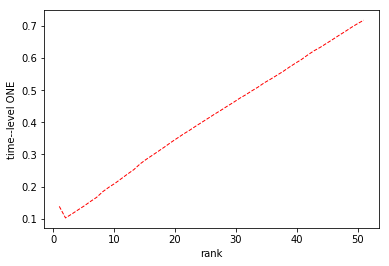

In [72]:
k_time1 = np.linspace(1,size+1,size)


plt.plot(k_time1,l_time1,color='red',linewidth=1.0,linestyle='--')

plt.ylabel('time--level ONE')
plt.xlabel('rank')
plt.show()

In [13]:
"""The list of the approximation value with different rank we set."""
l_logdet_method2 = []
for i in range(1,size+1):
    l_logdet_method2.append(logdet_method2(i,A,nboxes,n))

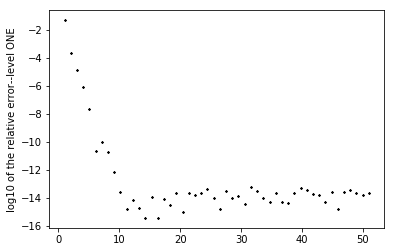

In [14]:
relative_error_2 = []
for i in range(size):
    a = (l_logdet_method2[i] - logdet1)/logdet1
    b = abs(a)
    if b == 0:
        relative_error_2.append(-16)
    else: 
        relative_error_2.append(np.log10(b))

k_det = np.linspace(1,size+1,size)
plt.plot(k_det,relative_error_2,'k*',markersize=2)
plt.ylabel('log10 of the relative error--level ONE') 
plt.show()

#### Second-level scheme

In [14]:
def get_box2(i,j,k,A,nboxes,n):
    mat_ = S_1(k,A,nboxes,n)[i*2*k:(i+1)*2*k,j*2*k:(j+1)*2*k]
    return mat_

In [16]:
def get_con_box_2(i,k,A,nboxes,n):
    """Return Ai in the second level"""
    BB = S_1(k,A,nboxes,n)[i*2*k : (i + 1)*2*k, :]
    B = np.delete(BB, np.s_[i*2*k : (i+1)*2*k], axis = 1)
    
    CC = np.transpose(S_1(k,A,nboxes,n)[:, i*2*k : (i + 1)*2*k])
    C = np.delete(CC, np.s_[i*2*k : (i+1)*2*k], axis = 1)
    return np.hstack((B,C))

In [17]:
def L_2(i,k,rank,A,nboxes,n):
    idx1,proj1 = sli.interp_decomp(get_con_box_2(i,k,A,nboxes,n), rank, rand = False)
    B1 = sli.reconstruct_skel_matrix(get_con_box_2(i,k,A,nboxes,n),rank,idx1)
    B1_trans = np.transpose(B1)
    
    idx2,proj2 = sli.interp_decomp(B1_trans, rank, rand = False)
    P2_trans = sli.reconstruct_interp_matrix(idx2,proj2)

    P2 = np.transpose(P2_trans)
    return P2,idx2

In [18]:
def index_set2(k,rank,A,nboxes,n):
    l = []
    for i in range(nboxes//2):
        l.append(L_2(i,k,rank,A,nboxes,n)[1][0:rank])
    return l

In [19]:
def S_2(k,rank,A,nboxes,n):
    ll = index_set2(k,rank,A,nboxes,n)
    mat = np.zeros((rank*(nboxes//2),rank*(nboxes//2)))
    for i in range(nboxes//2):
        for j in range(nboxes//2):
            if i != j:
                mat_ =  S_1(k,A,nboxes,n)[i*2*k:(i+1)*2*k,j*2*k:(j+1)*2*k][ll[i],:]
                mat[i*rank:(i+1)*rank,j*rank:(j+1)*rank] = mat_[:,ll[j]]
    return mat

In [20]:
def R_2(i,k,rank,A,nboxes,n):
    RR = np.transpose(L_2(i,k,rank,A,nboxes,n)[0])
    return RR

In [21]:
def logdet_method22(k,rank,A,nboxes,n):
    
    X = np.zeros((k*nboxes,k*nboxes))
    for i in range(nboxes//2):
        X[i*2*k:(i+1)*2*k,i*2*k:(i+1)*2*k] =  S_1(k,A,nboxes,n)[i*2*k:(i+1)*2*k,i*2*k:(i+1)*2*k]
        for j in range(nboxes):
            X[j*k:(j+1)*k,j*k:(j+1)*k] = np.linalg.inv(R_1(j,k,A,nboxes,n)@np.linalg.inv(get_box(j,j,A,nboxes,n))@L_1(j,k,A,nboxes,n)[0])
        
    Y = S_2(k,rank,A,nboxes,n)
    for i in range(nboxes//2):
        Y[i*rank:(i+1)*rank,i*rank:(i+1)*rank] = np.linalg.inv(R_2(i,k,rank,A,nboxes,n)@np.linalg.inv(X[i*2*k:(i+1)*2*k,i*2*k:(i+1)*2*k])@L_2(i,k,rank,A,nboxes,n)[0])
    
    
    a1 = 0                   #========================= Y ==============================
    p1,l1,u1 = scipy.linalg.lu(Y)
    for i in range(rank*(nboxes//2)):
        a1 += math.log(abs(u1[i,i]))
        
    a2 = 0                   #========================== D1 =============================
    for i in range (nboxes):
        p2,l2,u2 = scipy.linalg.lu(get_box(i,i,A,nboxes,n))
        for j in range(size):
            a2 +=math.log(abs(u2[j,j]))
            
    a3 = 0                   #==================== -R1.inv(D1).L1 =======================
    for i in range(nboxes):
        p3,l3,u3 = scipy.linalg.lu(-R_1(i,k,A,nboxes,n)@np.linalg.inv(get_box(i,i,A,nboxes,n)) @L_1(i,k,A,nboxes,n)[0] )
        for j in range(k):
            a3 += math.log(abs(u3[j,j]))
            
    a4 = 0                  #=================== X = D2 + inv(R1.inv(D1).L1) ============================
    for i in range(nboxes//2):
        p4,l4,u4 = scipy.linalg.lu(X[i*2*k:(i+1)*2*k,i*2*k:(i+1)*2*k])
        for j in range(2*k):
            a4 += math.log(abs(u4[j,j]))
    a5 = 0                  #================= -R2.inv(X)L2 ===============================
    for i in range(nboxes//2):
        p5,l5,u5 = scipy.linalg.lu(-R_2(i,k,rank,A,nboxes,n)@np.linalg.inv(X[i*2*k:(i+1)*2*k,i*2*k:(i+1)*2*k])@L_2(i,k,rank,A,nboxes,n)[0])
        for j in range(rank):
            a5 += math.log(abs(u5[j,j]))            
            
    return a1 + a2 + a3 + a4 + a5

In [90]:
def time_logdet2(rank,A,nboxes,n):
    start_time = time.time()
    a = logdet_method22(size//10,rank,A,nboxes,n)
    end_time = time.time()
    b = end_time - start_time
    return b

In [99]:
l_time2 = []
for i in range(1,size//5 + 1):
    l_time2.append(time_logdet2(i,A,nboxes,n))

In [101]:
len(l_time2)

10

In [35]:
"""The list of the approximation value with different rank we set in level 2."""
l_logdet_method22 = []
for i in range(1,6*size//10+1):
    l_logdet_method22.append(logdet_method22(3*size//10,i,A,nboxes,n))

In [36]:
relative_error_22 = []
for i in range(6*size//10):
    a = (l_logdet_method22[i] - logdet1)/logdet1
    b = abs(a)
    if b == 0:
        relative_error_22.append(-16)
    else: 
        relative_error_22.append(np.log10(b))

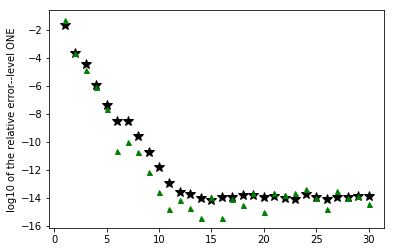

In [37]:
k_det = np.linspace(1,6*size//10,6*size//10)
plt.plot(k_det,relative_error_22[0:6*size//10],'k*',markersize=10)
plt.plot(k_det,relative_error_2[0:6*size//10],'g^',markersize=5)
plt.ylabel('log10 of the relative error--level ONE') 
plt.show()